# SATRN Baseline Code (step by step)

## import library

In [1]:
import os
import argparse
import multiprocessing
import numpy as np
import random
import time
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import yaml
import PIL
from tqdm import tqdm
from checkpoint import (
    default_checkpoint,
    load_checkpoint,
    save_checkpoint,
    init_tensorboard,
    write_tensorboard,
)
from psutil import virtual_memory

from flags import Flags
from utils import get_network, get_optimizer
from dataset import dataset_loader, START, PAD,load_vocab
from scheduler import CircularLRBeta

from metrics import word_error_rate,sentence_acc

## Argument Parsing

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument(
        "-c",
        "--config_file",
        dest="config_file",
        default="configs/SATRN.yaml",
        type=str,
        help="Path of configuration file",
    )
parser = parser.parse_args(args=[])

options = Flags(parser.config_file).get()

In [3]:
is_cuda = torch.cuda.is_available()
hardware = "cuda" if is_cuda else "cpu"
device = torch.device(hardware)

In [4]:
checkpoint = (
        load_checkpoint(options.checkpoint, cuda=is_cuda)
        if options.checkpoint != ""
        else default_checkpoint
    )
model_checkpoint = checkpoint["model"]

## Dataset

In [5]:
transformed = transforms.Compose(
        [
            # Resize so all images have the same size
            transforms.Resize((options.input_size.height, options.input_size.width)),
            transforms.ToTensor(),
        ])

train_data_loader, validation_data_loader, train_dataset, valid_dataset = dataset_loader(options, transformed)

In [6]:
print(len(train_dataset))
print(len(valid_dataset))

80000
20000


In [7]:
data_ex = next(iter(train_dataset))
print(data_ex)

{'path': '/opt/ml/input/data/train_dataset/images/train_69595.jpg', 'truth': {'text': 'x = a \\sin \\theta \\left( - \\frac { \\pi } { 2 } \\leq \\theta \\leq \\frac { \\pi } { 2 } \\right)', 'encoded': [0, 204, 180, 205, 158, 33, 229, 214, 82, 224, 102, 213, 224, 177, 213, 58, 33, 58, 82, 224, 102, 213, 224, 177, 213, 137, 1]}, 'image': tensor([[[0.5529, 0.5490, 0.5608,  ..., 0.7216, 0.7294, 0.7098],
         [0.5647, 0.5608, 0.5608,  ..., 0.7255, 0.7294, 0.7059],
         [0.5647, 0.5569, 0.5647,  ..., 0.7216, 0.7137, 0.7020],
         ...,
         [0.5961, 0.5686, 0.5843,  ..., 0.7490, 0.7373, 0.7412],
         [0.5882, 0.5686, 0.5725,  ..., 0.7569, 0.7373, 0.7490],
         [0.5961, 0.5725, 0.5765,  ..., 0.7451, 0.7451, 0.7529]],

        [[0.5255, 0.5216, 0.5294,  ..., 0.7373, 0.7137, 0.6784],
         [0.5333, 0.5333, 0.5294,  ..., 0.7412, 0.7137, 0.6784],
         [0.5294, 0.5216, 0.5294,  ..., 0.7373, 0.7020, 0.6745],
         ...,
         [0.5647, 0.5412, 0.5608,  ..., 0.717

## Learning process

### 1. Data load

In [8]:
data = next(iter(train_data_loader))
input = data["image"].cuda()
expected = data["truth"]["encoded"].cuda()

In [9]:
print(input.shape)
print(data['truth']['text'])
print(len(data['truth']['text'][0].split(' ')))

torch.Size([1, 3, 128, 128])
['y + z = 4']
5


In [10]:
print(expected)
print(len(expected[0]))

tensor([[  0,  99, 108, 134, 180,  85,   1]], device='cuda:0')
7


In [11]:
expected[expected == -1] = train_data_loader.dataset.token_to_id[PAD]

### 2. Network load

In [12]:
model = get_network(
        options.network,
        options,
        model_checkpoint,
        device,
        train_dataset,
    )
model.cuda()
model.train()

SATRN(
  (encoder): TransformerEncoderFor2DFeatures(
    (shallow_cnn): DeepCNN300(
      (conv0): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (block1): DenseBlock(
        (block): Sequential(
          (0): BottleneckBlock(
            (norm1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv1): Conv2d(48, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(72, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
          (1): BottleneckB

In [13]:
model._modules.keys()

odict_keys(['encoder', 'decoder', 'criterion'])

### 3. Forward path

In [14]:
output = model(input, expected, True, 1)

In [15]:
print(output)
print(output.shape)

tensor([[[-18.2469,  -1.3696,   0.8695,  ...,  -1.0756,   1.6884, -19.2879],
         [-16.8658,  -0.1463,  -2.1397,  ...,  -5.1074,  -0.6528, -16.7589],
         [-13.5465,   0.7894,  -1.7902,  ...,  -5.5805,   4.7035, -14.5676],
         [-18.7364,   3.2667,  -0.5492,  ...,  -4.9563,  -0.4221, -19.6818],
         [-15.6682,   3.3433,  -1.4069,  ...,  -4.5657,  -2.5843, -15.6393],
         [-16.3401,   9.7989,   2.5950,  ...,  -5.7262,  -0.8503, -17.3222]]],
       device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 6, 245])


## Network (Encoder / Decoder)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random

from dataset import START, PAD
from networks.SATRN import TransformerEncoderFor2DFeatures, TransformerDecoder

### 1. Data

In [17]:
print(input.shape)
print(data['truth']['text'])
print(len(data['truth']['text'][0].split(' ')))

torch.Size([1, 3, 128, 128])
['y + z = 4']
5


In [18]:
print(expected)
print(len(expected[0]))

tensor([[  0,  99, 108, 134, 180,  85,   1]], device='cuda:0')
7


### 2. Encoder

- input_size : input data channel dim
- hidden_dim : cnn 통과한 featrue map channel dim
- filter_size : transformer encoder layer -> feed forward layer 의 중간 dim
- head_num : transformer encoder layer -> multi-head attention 의 head num
- layer_num : transformer encoder layer 의 num
- dropout_rate : cnn -> dense block -> bottle neck block 내부 dropout rate

In [33]:
input_size=options.data.rgb
hidden_dim=options.SATRN.encoder.hidden_dim
filter_size=options.SATRN.encoder.filter_dim
head_num=options.SATRN.encoder.head_num
layer_num=options.SATRN.encoder.layer_num
dropout_rate=options.dropout_rate

In [34]:
encoder = TransformerEncoderFor2DFeatures(input_size, hidden_dim, filter_size, head_num, layer_num, dropout_rate)

In [35]:
encoder.cuda()

TransformerEncoderFor2DFeatures(
  (shallow_cnn): DeepCNN300(
    (conv0): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block1): DenseBlock(
      (block): Sequential(
        (0): BottleneckBlock(
          (norm1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv1): Conv2d(48, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(72, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (1): BottleneckBlock(
          (norm1): BatchNorm2d(72, eps=1e-05, 

In [36]:
encoder_result = encoder(input)

In [37]:
encoder_result.shape

torch.Size([1, 256, 300])

### 3. decoder

- num_classes : token num, classifier dim
- src_dim : transformer decoder layer -> multi head attention 의 key dim 
- hidden_dim : word embedding dim, 
- filter_dim : transformer decoder layer -> feed forward layer 의 중간 filter size 
- head_num : tansformer decoder layer -> multi-head attention 의 head num
- dropout_rate :position encoder, transformer decoder 에 drop out
- pad_id : PAD token id
- st_id : SOS token id
- layer_num : transformer decoder num

In [38]:
num_classes=len(train_dataset.id_to_token)
src_dim=options.SATRN.decoder.src_dim
hidden_dim=options.SATRN.decoder.hidden_dim
filter_dim=options.SATRN.decoder.filter_dim
head_num=options.SATRN.decoder.head_num
dropout_rate=options.dropout_rate
pad_id=train_dataset.token_to_id[PAD]
st_id=train_dataset.token_to_id[START]
layer_num=options.SATRN.decoder.layer_num

In [46]:
decoder = TransformerDecoder(num_classes, src_dim, hidden_dim, filter_dim, head_num, dropout_rate, pad_id, st_id, layer_num)

In [47]:
decoder.cuda()

TransformerDecoder(
  (embedding): Embedding(246, 128)
  (pos_encoder): PositionEncoder1D(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attention_layers): ModuleList(
    (0): TransformerDecoderLayer(
      (self_attention_layer): MultiHeadAttention(
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=128, out_features=128, bias=True)
        (v_linear): Linear(in_features=128, out_features=128, bias=True)
        (attention): ScaledDotProductAttention(
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (out_linear): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (self_attention_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention_layer): MultiHeadAttention(
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=300, out_features=128, bias=True)
        

In [50]:
print(encoder_result.shape)
print(expected[:, :-1])
print(expected.size(1))

torch.Size([1, 256, 300])
tensor([[  0,  99, 108, 134, 180,  85]], device='cuda:0')
7


In [48]:
decoder_result = decoder(encoder_result, expected[:, :-1], True, expected.size(1), 1)

In [49]:
decoder_result.shape

torch.Size([1, 6, 245])

## Encoder

In [54]:
from networks.SATRN import DeepCNN300, PositionalEncoding2D, TransformerEncoderLayer

### 1. data

In [51]:
print(input.shape)
print(data['truth']['text'])
print(len(data['truth']['text'][0].split(' ')))

torch.Size([1, 3, 128, 128])
['y + z = 4']
5


In [52]:
print(expected)
print(len(expected[0]))

tensor([[  0,  99, 108, 134, 180,  85,   1]], device='cuda:0')
7


### 2. argument

- input_size : input data channel dim
- hidden_dim : cnn 통과한 featrue map channel dim
- filter_size : transformer encoder layer -> feed forward layer 의 중간 dim
- head_num : transformer encoder layer -> multi-head attention 의 head num
- layer_num : transformer encoder layer 의 num
- dropout_rate : cnn -> dense block -> bottle neck block 내부 dropout rate

In [53]:
input_size=options.data.rgb
hidden_dim=options.SATRN.encoder.hidden_dim
filter_size=options.SATRN.encoder.filter_dim
head_num=options.SATRN.encoder.head_num
layer_num=options.SATRN.encoder.layer_num
dropout_rate=options.dropout_rate

### 3. DeepCNN300

In [55]:
shallow_cnn = DeepCNN300(
            input_size,
            num_in_features=48,
            output_channel=hidden_dim,
            dropout_rate=dropout_rate,
        )

In [56]:
shallow_cnn.cuda()

DeepCNN300(
  (conv0): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block1): DenseBlock(
    (block): Sequential(
      (0): BottleneckBlock(
        (norm1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv1): Conv2d(48, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(72, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): BottleneckBlock(
        (norm1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=

In [57]:
cnn_result = shallow_cnn(input)

In [58]:
cnn_result.shape

torch.Size([1, 300, 16, 16])

### 4. Positional encoding

In [59]:
positional_encoding = PositionalEncoding2D(hidden_dim)

In [60]:
positional_encoding.cuda()

PositionalEncoding2D(
  (h_linear): Linear(in_features=150, out_features=150, bias=True)
  (w_linear): Linear(in_features=150, out_features=150, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [61]:
position_result = positional_encoding(cnn_result)

In [62]:
position_result.shape

torch.Size([1, 300, 16, 16])

### 5. Attention layer

In [63]:
attention_layers = nn.ModuleList(
            [
                TransformerEncoderLayer(hidden_dim, filter_size, head_num, dropout_rate)
                for _ in range(layer_num)
            ]
        )

In [64]:
attention_layers.cuda()

ModuleList(
  (0): TransformerEncoderLayer(
    (attention_layer): MultiHeadAttention(
      (q_linear): Linear(in_features=300, out_features=296, bias=True)
      (k_linear): Linear(in_features=300, out_features=296, bias=True)
      (v_linear): Linear(in_features=300, out_features=296, bias=True)
      (attention): ScaledDotProductAttention(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (out_linear): Linear(in_features=296, out_features=300, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (attention_norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (feedforward_layer): Feedforward(
      (layers): Sequential(
        (0): Linear(in_features=300, out_features=600, bias=True)
        (1): ReLU(inplace=True)
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=600, out_features=300, bias=True)
        (4): ReLU(inplace=True)
        (5): Dropout(p=0.1, inplace=False)
      )
    )
    (feedforward_norm): LayerNorm

In [65]:
position_result.shape

torch.Size([1, 300, 16, 16])

In [67]:
# flatten
b, c, h, w = position_result.size()
out = position_result.view(b, c, h * w).transpose(1, 2)  # [b, h x w, c]

In [68]:
out.shape

torch.Size([1, 256, 300])

In [70]:
for layer in attention_layers:
    out = layer(out)

In [71]:
out.shape

torch.Size([1, 256, 300])

## Positional encoding

In [73]:
in_channels = hidden_dim 
max_h=64 
max_w=128 
dropout=0.1

### 1. Data

In [72]:
cnn_result.shape

torch.Size([1, 300, 16, 16])

### 2. postion encoding

In [114]:
def generate_encoder(in_channels, max_len):
        pos = torch.arange(max_len).float().unsqueeze(1)
        print(pos.shape)
        i = torch.arange(in_channels).float().unsqueeze(0)
        print(i.shape)
        angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / in_channels)
        print(angle_rates.shape)
        position_encoder = pos * angle_rates
        print(position_encoder.shape)
        position_encoder[:, 0::2] = torch.sin(position_encoder[:, 0::2])
        position_encoder[:, 1::2] = torch.cos(position_encoder[:, 1::2])
        return position_encoder  # (Max_len, In_channel)

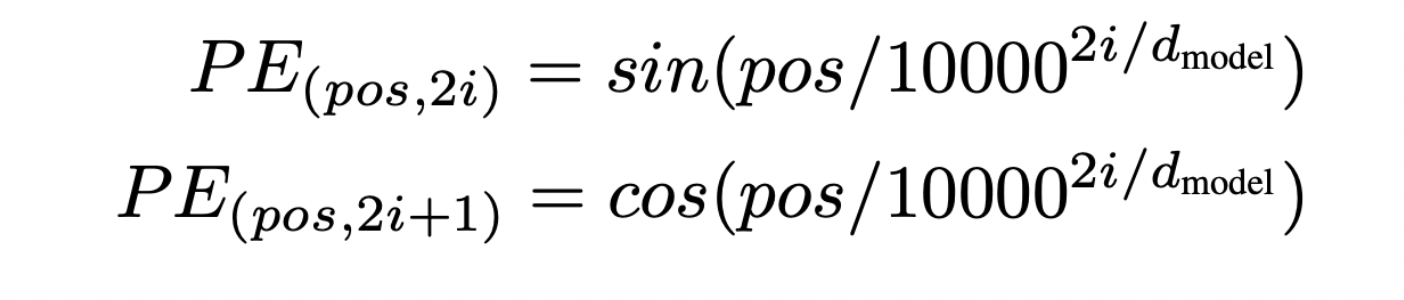

### 3. 2D position encoding

In [115]:
h_position_encoder = generate_encoder(in_channels // 2, max_h)
w_position_encoder = generate_encoder(in_channels // 2, max_w)

torch.Size([64, 1])
torch.Size([1, 150])
torch.Size([1, 150])
torch.Size([64, 150])
torch.Size([128, 1])
torch.Size([1, 150])
torch.Size([1, 150])
torch.Size([128, 150])


In [89]:
print(h_position_encoder.cuda().shape)
print(w_position_encoder.cuda().shape)

torch.Size([64, 150])
torch.Size([128, 150])


In [91]:
h_linear = nn.Linear(in_channels // 2, in_channels // 2)
h_linear.cuda()
print(h_linear)
w_linear = nn.Linear(in_channels // 2, in_channels // 2)
w_linear.cuda()
print(w_linear)

Linear(in_features=150, out_features=150, bias=True)
Linear(in_features=150, out_features=150, bias=True)


In [88]:
dropout = nn.Dropout(p=dropout)
dropout.cuda()

Dropout(p=0.1, inplace=False)

### 3. forward path

In [93]:
b, c, h, w = cnn_result.size()
print(b,c,h,w)

1 300 16 16


In [98]:
h_pos_encoding = (
            h_position_encoder[:h, :].unsqueeze(1).cuda()
        )
print(h_pos_encoding.shape)

torch.Size([16, 1, 150])


In [99]:
h_pos_encoding = h_linear(h_pos_encoding)  # [H, 1, D]
print(h_pos_encoding.shape)

torch.Size([16, 1, 150])


In [101]:
w_pos_encoding = (
            w_position_encoder[:w, :].unsqueeze(0).cuda()
        )
print(w_pos_encoding.shape)

torch.Size([1, 16, 150])


In [102]:
w_pos_encoding = w_linear(w_pos_encoding)  # [1, W, D]
print(w_pos_encoding.shape)

torch.Size([1, 16, 150])


In [104]:
h_pos_encoding = h_pos_encoding.expand(-1, w, -1)   # h, w, c/2
print(h_pos_encoding.shape)
w_pos_encoding = w_pos_encoding.expand(h, -1, -1)   # h, w, c/2
print(w_pos_encoding.shape)

torch.Size([16, 16, 150])
torch.Size([16, 16, 150])


In [105]:
pos_encoding = torch.cat([h_pos_encoding, w_pos_encoding], dim=2)  # [H, W, 2*D]
print(pos_encoding.shape)

torch.Size([16, 16, 300])


In [106]:
pos_encoding = pos_encoding.permute(2, 0, 1)  # [2*D, H, W]
print(pos_encoding.shape)

torch.Size([300, 16, 16])


In [107]:
out = cnn_result + pos_encoding.unsqueeze(0)
print(out.shape)

torch.Size([1, 300, 16, 16])


In [108]:
out = dropout(out)
print(out.shape)

torch.Size([1, 300, 16, 16])


### 4. Adaptive 2D positional encoding

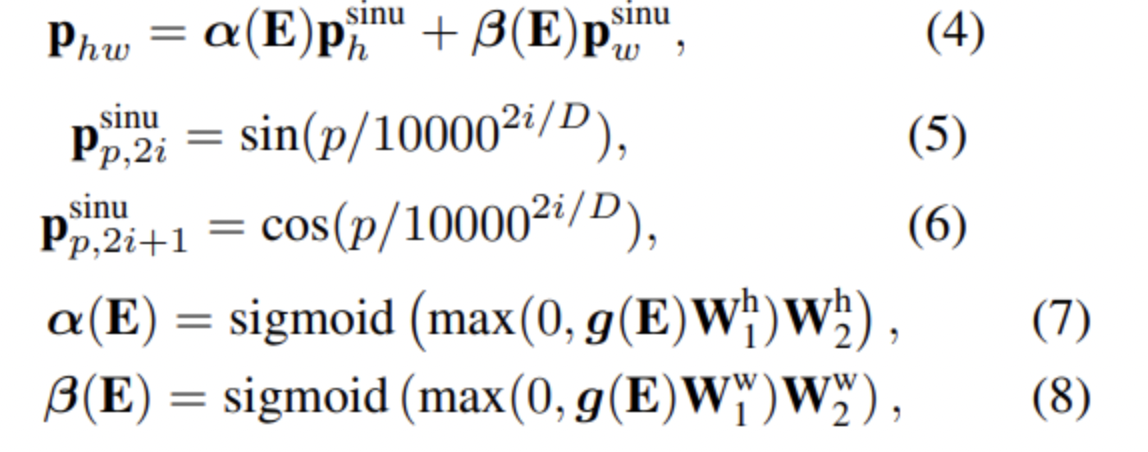

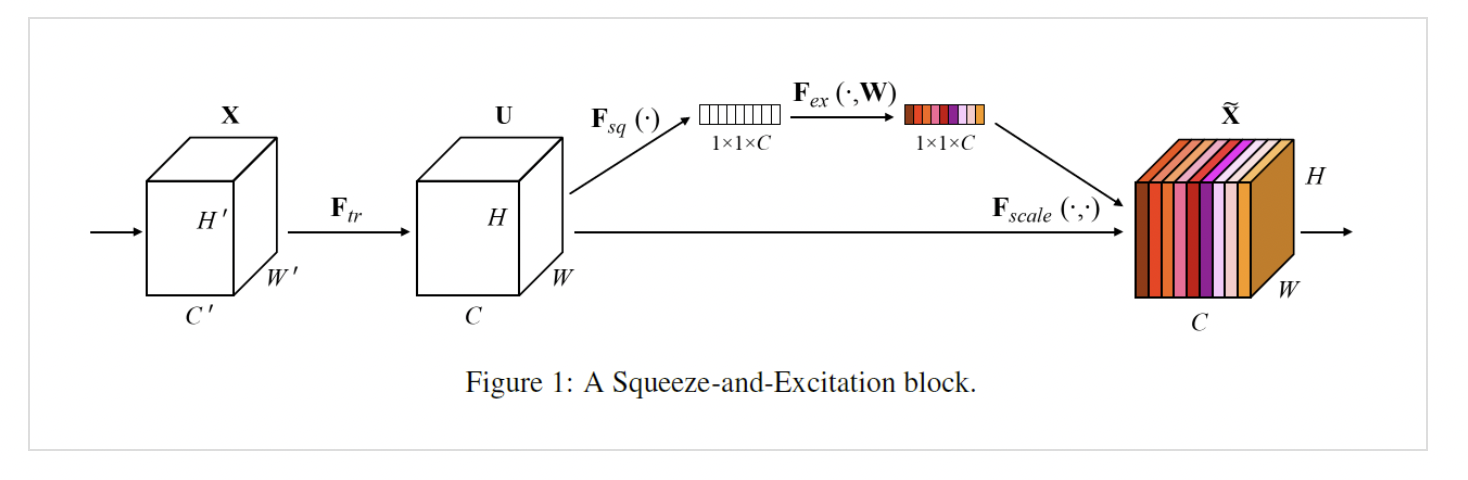

- featrue map, position embedding

In [162]:
print(cnn_result.shape)
print(h_pos_encoding.shape)
print(w_pos_encoding.shape)

torch.Size([1, 300, 16, 16])
torch.Size([16, 16, 150])
torch.Size([16, 16, 150])


- Parameter

In [126]:
avgpool = nn.AvgPool2d(cnn_result.size()[2])

In [138]:
w1 = nn.Linear(300, 150).cuda()
w2 = nn.Linear(150, 150).cuda()
h1 = nn.Linear(300, 150).cuda()
h2 = nn.Linear(150, 150).cuda()

- forward

In [163]:
g = avgpool(cnn_result)
print(g.shape)

torch.Size([1, 300, 1, 1])


In [164]:
g = g.squeeze(-1)
g = g.squeeze(-1)
alpha = w1(g)
beta = h1(g)
print(alpha.shape)
print(beta.shape)

torch.Size([1, 150])
torch.Size([1, 150])


In [165]:
alpha = F.relu(alpha)
beta = F.relu(beta)

In [166]:
alpha = w2(alpha)
beta = h2(beta)

In [167]:
alpha = torch.sigmoid(alpha)
beta = torch.sigmoid(beta)

In [168]:
print(alpha.shape)
print(beta.shape)

torch.Size([1, 150])
torch.Size([1, 150])


In [169]:
alpha = alpha.unsqueeze(0)
beta = beta.unsqueeze(0)
print(alpha.shape)
print(beta.shape)

torch.Size([1, 1, 150])
torch.Size([1, 1, 150])


In [170]:
w_pos_encoding = alpha * w_pos_encoding
h_pos_encoding = beta * h_pos_encoding
print(w_pos_encoding.shape)
print(h_pos_encoding.shape)

torch.Size([16, 16, 150])
torch.Size([16, 16, 150])


- concat

In [171]:
pos_encoding = torch.cat([h_pos_encoding, w_pos_encoding], dim=2)  # [H, W, 2*D]
print(pos_encoding.shape)

torch.Size([16, 16, 300])


In [172]:
pos_encoding = pos_encoding.permute(2, 0, 1)  # [2*D, H, W]
print(pos_encoding.shape)

torch.Size([300, 16, 16])


In [173]:
out = cnn_result + pos_encoding.unsqueeze(0)
print(out.shape)

torch.Size([1, 300, 16, 16])


In [174]:
out = dropout(out)
print(out.shape)

torch.Size([1, 300, 16, 16])
